In [1]:
! pip install wn

import nltk
import random
import json
import re
import numpy as np
import wn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
from collections import Counter

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 9.5 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
try:
    wn.download("omw-en")
except:
    print("w_Data cant be downloaded.")

with open("contractions_dict.json", "r") as contractions:
        contractions_dict = json.load(contractions)

Download [##############################] (10709600/10709600 bytes) Complete
Read [##############################] (1221564/1221564) 
Added omw-en:1.4 (OMW English Wordnet based on WordNet 3.0)



In [3]:
class PreProcessing:

    class Tokenizer:

        def __init__(self):
            try:
                self.wordnet = wn
                self.MWEs = self.list_MWEs() # converts new york to -> New_york - as its one entity
            except:
                print("WordNet initialization failed. Using basic tokenization.")
                self.MWEs = []
                #Replacing or extracting parts of strings.
                #Cleaning and preprocessing text.

            self.compile_regex_patterns()

        def list_MWEs(self):
            MWEs = []

            try:
                # Get multi-word nouns
                nouns = self.wordnet.synsets(pos="n")
                MWEs.extend([syn.lemmas()[0] for syn in nouns if " " in syn.lemmas()[0]])

                # Get multi-word verbs
                verbs = self.wordnet.synsets(pos="v")
                MWEs.extend([syn.lemmas()[0] for syn in verbs if " " in syn.lemmas()[0]])
            except:
                print("Error extracting MWEs. Using empty list.")

            return MWEs

        def compile_regex_patterns(self):

            if self.MWEs:
                mwe_patterns = [rf"\b{re.escape(mwe)}\b" for mwe in self.MWEs]

                self.regex_pattern = re.compile("|".join(mwe_patterns))
            else:
                self.regex_pattern = re.compile(r"")

            self.hyphen_pattern = re.compile(r"\b(\w+)-(\w+)\b")

            self.number_unit_pattern = re.compile(r"(\d+)([a-zA-Z]+)")

            self.punctuation_pattern = re.compile(r"[^\w\s\-_]")

            self.contraction_pattern = re.compile(r"\b(" + "|".join(map(re.escape, contractions_dict.keys())) + r")\b", re.IGNORECASE)

        def tokenize(self, text):
            """Tokenize the input text with preprocessing steps."""
            text = text.lower()

            if self.MWEs:
                text = self.regex_pattern.sub(lambda match: match.group(0).replace(" ", "_"), text)

            text = self.contraction_pattern.sub(lambda match: contractions_dict.get(match.group(0).lower(), match.group(0)), text)

            text = self.hyphen_pattern.sub(r"\1 \2", text)

            text = self.number_unit_pattern.sub(r"\1_\2", text)

            text = self.punctuation_pattern.sub("", text)

            tokens = text.split()
            return tokens

    class tf_idf_Vectorizer:

        def __init__(self, max_features=None):
            self.vocabulary = {}
            self.idf = {}
            self.max_features = max_features
            self.fitted = False

        def fit(self, corpus):
            if isinstance(corpus[0], str):
                tokenizer = PreProcessing.Tokenizer()
                corpus = [tokenizer.tokenize(doc) for doc in corpus]
            elif not isinstance(corpus[0], list):
                raise ValueError("Corpus must be a list of strings or tokenized documents (list of lists).")

            df = Counter()
            for doc in corpus:
                unique_words = set(doc)
                df.update(unique_words)

            sorted_words = [word for word, _ in df.most_common(self.max_features)] if self.max_features else list(df.keys())

            self.vocabulary = {word: idx for idx, word in enumerate(sorted_words)}

            N = len(corpus)
            self.idf = {word: np.log((N + 1) / (df[word] + 1)) + 1 for word in self.vocabulary}

            self.fitted = True
            return self

        def transform(self, documents):
            if not self.fitted:
                raise ValueError("Vectorizer needs to be fitted before transform")

            if isinstance(documents[0], str):
                tokenizer = PreProcessing.Tokenizer()
                documents = [tokenizer.tokenize(doc) for doc in documents]
            elif not isinstance(documents[0], list):
                raise ValueError("Input documents must be strings or tokenized documents (list of lists).")

            tfidf_matrix = np.zeros((len(documents), len(self.vocabulary)))

            for i, doc in enumerate(documents):
                tf = Counter(doc)
                total_words = len(doc)

                for word, count in tf.items():
                    if word in self.vocabulary:
                        word_idx = self.vocabulary[word]
                        tfidf_matrix[i][word_idx] = (count / total_words) * self.idf.get(word, 0)

            return tfidf_matrix

        def fit_transform(self, documents):
            self.fit(documents)
            return self.transform(documents)


In [4]:
def synonym_replacement(tokens, limit):
    augmented_sentences = []
    for i in range(len(tokens)):
        synonyms = []
        for syn in wordnet.synsets(tokens[i]):
            for lemma in syn.lemmas():
                synonyms.append(lemma.name())
        if len(synonyms) > 0:
            num_augmentations = min(limit, len(synonyms))
            sampled_synonyms = random.sample(synonyms, num_augmentations)
            for synonym in sampled_synonyms:
                augmented_tokens = tokens[:i] + [synonym] + tokens[i+1:]
                augmented_sentences.append(' '.join(augmented_tokens))
    return augmented_sentences

In [5]:
with open('intents.json', 'r') as f:
    intents = json.load(f)

In [6]:
tokenizer = PreProcessing.Tokenizer()
vectorizer = PreProcessing.tf_idf_Vectorizer(max_features=1000)

In [7]:
text_data = []
labels = []
stopwords = set(nltk.corpus.stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet


limit_per_tag = 40

for intent in intents['intents']:
    augmented_sentences_per_tag = 0
    for example in intent['patterns']:
        tokens = nltk.word_tokenize(example.lower())
        filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords and token.isalpha()]
        if filtered_tokens:
            text_data.append(' '.join(filtered_tokens))
            labels.append(intent['tag'])

            augmented_sentences = synonym_replacement(filtered_tokens, limit_per_tag - augmented_sentences_per_tag)
            for augmented_sentence in augmented_sentences:
                text_data.append(augmented_sentence)
                labels.append(intent['tag'])
                augmented_sentences_per_tag += 1
                if augmented_sentences_per_tag >= limit_per_tag:
                    break

print(len(text_data))
print(len(labels))

3202
3202


In [8]:
X = vectorizer.fit_transform(text_data)
y = labels

In [9]:
import numpy as np
import os
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from joblib import Parallel, delayed
from scipy.sparse import issparse

class MultinomialNBFromScratch(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha=1.0):
        self.alpha = alpha  # Smoothing parameter

    def fit(self, X, y):
        X, y = check_X_y(X, y, accept_sparse=True)
        self.classes_ = unique_labels(y)
        n_classes = len(self.classes_)
        n_features = X.shape[1]

        # Convert sparse matrix to dense if needed
        X_array = X.toarray() if issparse(X) else X

        # Ensure all values are non-negative for Multinomial NB
        if np.any(X_array < 0):
            raise ValueError("Input X must be non-negative for MultinomialNB")

        # Initialize parameters
        self.class_count_ = np.zeros(n_classes, dtype=np.float64)
        self.feature_count_ = np.zeros((n_classes, n_features), dtype=np.float64)

        # Count samples in each class
        for i, c in enumerate(self.classes_):
            X_c = X_array[y == c]
            self.class_count_[i] = X_c.shape[0]
            self.feature_count_[i] = np.sum(X_c, axis=0)

        # Calculate log probabilities with smoothing
        smoothed_fc = self.feature_count_ + self.alpha
        smoothed_cc = np.sum(smoothed_fc, axis=1)

        self.feature_log_prob_ = np.log(smoothed_fc) - np.log(smoothed_cc.reshape(-1, 1))
        self.class_log_prior_ = np.log(self.class_count_) - np.log(np.sum(self.class_count_))

        return self

    def predict_log_proba(self, X):
        check_is_fitted(self, ['feature_log_prob_', 'class_log_prior_'])
        X = check_array(X, accept_sparse=True)

        # Convert sparse matrix to dense if needed
        X_array = X.toarray() if issparse(X) else X

        # Calculate log probabilities for each class
        joint_log_likelihood = np.zeros((X_array.shape[0], len(self.classes_)))

        for i, c in enumerate(self.classes_):
            joint_log_likelihood[:, i] = self.class_log_prior_[i]
            joint_log_likelihood[:, i] += np.dot(X_array, self.feature_log_prob_[i])

        # Normalize to get probabilities (using logsumexp trick for numerical stability)
        log_prob_x = np.max(joint_log_likelihood, axis=1)
        log_prob_x_adjusted = log_prob_x + np.log(np.sum(
            np.exp(joint_log_likelihood - log_prob_x.reshape(-1, 1)), axis=1
        ))
        log_probas = joint_log_likelihood - log_prob_x_adjusted.reshape(-1, 1)

        return log_probas

    def predict_proba(self, X):
        return np.exp(self.predict_log_proba(X))

    def predict(self, X):
        log_probas = self.predict_log_proba(X)
        return self.classes_[np.argmax(log_probas, axis=1)]


class DecisionTreeClassifierFromScratch(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1,
                 criterion='gini', max_features=None, random_state=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.max_features = max_features
        self.random_state = random_state
        self.tree_ = None
        self.feature_importances_ = None

    class Node:
        def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
            self.feature = feature  # Which feature to split on
            self.threshold = threshold  # Threshold value for the split
            self.left = left  # Left child
            self.right = right  # Right child
            self.value = value  # Class distribution or prediction

    def _gini(self, y):
        """Calculate Gini impurity"""
        m = len(y)
        if m == 0:
            return 0

        # Use bincount with proper handling of class indices
        counts = np.bincount(y, minlength=len(self.classes_))
        probas = counts / m
        return 1 - np.sum(probas**2)

    def _entropy(self, y):
        """Calculate entropy"""
        m = len(y)
        if m == 0:
            return 0

        # Use bincount with proper handling of class indices
        counts = np.bincount(y, minlength=len(self.classes_))
        probas = counts / m
        # Avoid log(0) by filtering zero probabilities
        nonzero_probas = probas[probas > 0]
        return -np.sum(nonzero_probas * np.log2(nonzero_probas))

    def _calculate_impurity(self, y):
        """Calculate impurity based on the criterion"""
        if self.criterion == 'gini':
            return self._gini(y)
        elif self.criterion == 'entropy':
            return self._entropy(y)
        else:
            raise ValueError(f"Unknown criterion: {self.criterion}")

    def _best_split(self, X, y, features_to_consider):
        """Find the best split for the data"""
        m, n = X.shape
        if m <= 1:
            return None, None

        # Get current impurity
        current_impurity = self._calculate_impurity(y)

        best_gain = 0.0
        best_feature, best_threshold = None, None

        # Only consider the randomly selected features
        for feature in features_to_consider:
            # Get unique values for the feature
            feature_values = X[:, feature]

            # Check if all values are identical
            if np.all(feature_values == feature_values[0]):
                continue

            # Use a more efficient approach for finding potential thresholds
            # Instead of using every unique value, sample a reasonable number of thresholds
            # For small datasets, still use all unique values
            unique_values = np.unique(feature_values)
            if len(unique_values) > 10:
                # For large number of unique values, use percentiles instead
                percentiles = np.linspace(5, 95, 10)
                thresholds = np.percentile(feature_values, percentiles)
            else:
                thresholds = unique_values

            # Try each threshold
            for threshold in thresholds:
                # Split the data
                left_indices = X[:, feature] <= threshold
                right_indices = ~left_indices

                # Skip if either side has fewer than min_samples_leaf
                if np.sum(left_indices) < self.min_samples_leaf or np.sum(right_indices) < self.min_samples_leaf:
                    continue

                # Calculate impurity for each side
                left_impurity = self._calculate_impurity(y[left_indices])
                right_impurity = self._calculate_impurity(y[right_indices])

                # Calculate the weighted average impurity
                n_left, n_right = np.sum(left_indices), np.sum(right_indices)
                weighted_impurity = (n_left / m) * left_impurity + (n_right / m) * right_impurity

                # Calculate information gain
                gain = current_impurity - weighted_impurity

                # Update best split if this is better
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _select_features(self, n_features, random_state=None):
        """Select features to consider for splitting"""
        if self.max_features is None:
            return np.arange(n_features)

        rng = np.random.RandomState(random_state)

        if isinstance(self.max_features, int):
            n_features_to_consider = min(self.max_features, n_features)
        elif isinstance(self.max_features, float):
            n_features_to_consider = max(1, int(self.max_features * n_features))
        elif self.max_features == 'sqrt':
            n_features_to_consider = max(1, int(np.sqrt(n_features)))
        elif self.max_features == 'log2':
            n_features_to_consider = max(1, int(np.log2(n_features)))
        else:
            n_features_to_consider = n_features

        return rng.choice(n_features, size=n_features_to_consider, replace=False)

    def _build_tree(self, X, y, depth=0, node_idx=0, feature_importances=None):
        """Recursively build the decision tree"""
        n_samples, n_features = X.shape

        # Convert class labels to indices for proper bincount
        y_idx = np.searchsorted(self.classes_, y)

        # Get the class distribution (use the class indices to ensure proper counts)
        value = np.bincount(y_idx, minlength=len(self.classes_))

        # Create a leaf node if stopping criteria are met
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split or \
           n_samples < 2 * self.min_samples_leaf or \
           np.unique(y).size == 1:
            return self.Node(value=value)

        # Select features to consider (for random forest)
        features_to_consider = self._select_features(
            n_features,
            random_state=self.random_state + node_idx if self.random_state is not None else None
        )

        # Find the best split
        best_feature, best_threshold = self._best_split(X, y_idx, features_to_consider)

        # If no good split was found, create a leaf node
        if best_feature is None:
            return self.Node(value=value)

        # Split the data
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = ~left_indices

        # Track feature importance
        if feature_importances is not None:
            # Compute node impurity reduction and weight by node size
            current_impurity = self._calculate_impurity(y_idx)
            left_impurity = self._calculate_impurity(y_idx[left_indices])
            right_impurity = self._calculate_impurity(y_idx[right_indices])

            n_left, n_right = np.sum(left_indices), np.sum(right_indices)
            weighted_impurity = (n_left / n_samples) * left_impurity + (n_right / n_samples) * right_impurity

            # Update feature importance
            impurity_decrease = current_impurity - weighted_impurity
            feature_importances[best_feature] += impurity_decrease

        # Build subtrees
        left_subtree = self._build_tree(
            X[left_indices], y[left_indices],
            depth + 1, node_idx * 2 + 1, feature_importances
        )
        right_subtree = self._build_tree(
            X[right_indices], y[right_indices],
            depth + 1, node_idx * 2 + 2, feature_importances
        )

        return self.Node(
            feature=best_feature,
            threshold=best_threshold,
            left=left_subtree,
            right=right_subtree,
            value=value
        )

    def fit(self, X, y):
        # Check that X and y have correct shape and convert sparse to dense
        X, y = check_X_y(X, y, accept_sparse=True)

        # Convert sparse matrix to dense if needed
        X_array = X.toarray() if issparse(X) else X

        self.classes_ = unique_labels(y)

        # Initialize feature importances array
        self.feature_importances_ = np.zeros(X_array.shape[1])

        # Set random seed if provided
        if self.random_state is not None:
            np.random.seed(self.random_state)

        # Build the tree
        self.tree_ = self._build_tree(X_array, y, feature_importances=self.feature_importances_)

        # Normalize feature importances to sum to 1
        if np.sum(self.feature_importances_) > 0:
            self.feature_importances_ /= np.sum(self.feature_importances_)

        return self

    def _predict_one(self, x, node):
        """Predict for a single instance"""
        if node.feature is None:  # Leaf node
            # Handle division by zero safely
            if np.sum(node.value) == 0:
                # Return uniform distribution if value is all zeros
                return np.ones(len(self.classes_)) / len(self.classes_)
            return node.value / np.sum(node.value)  # Return probability distribution

        if x[node.feature] <= node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

    def predict_proba(self, X):
        check_is_fitted(self, ['tree_', 'classes_'])
        X = check_array(X, accept_sparse=True)

        # Convert sparse matrix to dense if needed
        X_array = X.toarray() if issparse(X) else X

        # Make predictions for each instance
        probas = np.array([self._predict_one(x, self.tree_) for x in X_array])

        return probas

    def predict(self, X):
        probas = self.predict_proba(X)
        return self.classes_[np.argmax(probas, axis=1)]

class RandomForestClassifierFromScratch(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2,
                 min_samples_leaf=1, criterion='gini', max_features='sqrt',
                 bootstrap=True, random_state=None, n_jobs=-1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.estimators_ = []
        self.feature_importances_ = None

    def _bootstrap_sample(self, X, y, random_state):
        """Create a bootstrap sample for a single tree"""
        n_samples = X.shape[0]
        rng = np.random.RandomState(random_state)

        if self.bootstrap:
            indices = rng.choice(range(n_samples), size=n_samples, replace=True)
        else:
            indices = np.arange(n_samples)

        return X[indices], y[indices]

    def _build_tree(self, X, y, tree_idx):
        """Build a single decision tree"""
        # Set random state for both bootstrapping and tree building
        tree_random_state = None
        if self.random_state is not None:
            tree_random_state = self.random_state + tree_idx

        # Create a decision tree
        tree = DecisionTreeClassifierFromScratch(
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            criterion=self.criterion,
            max_features=self.max_features,
            random_state=tree_random_state
        )

        # Get bootstrap sample
        X_sample, y_sample = self._bootstrap_sample(X, y, tree_random_state)

        # Fit the tree on the bootstrap sample
        tree.fit(X_sample, y_sample)

        return tree

    def fit(self, X, y):
        # Check that X and y have correct shape and convert sparse to dense
        X, y = check_X_y(X, y, accept_sparse=True)

        # Convert sparse matrix to dense if needed
        X_array = X.toarray() if issparse(X) else X

        self.classes_ = unique_labels(y)
        self.n_features_in_ = X_array.shape[1]

        # Set the global random state if provided
        if self.random_state is not None:
            np.random.seed(self.random_state)

        # Get number of jobs
        n_jobs = self.n_jobs
        if n_jobs < 0:
            n_jobs = min(abs(n_jobs), os.cpu_count() or 1)
            n_jobs = max(1, n_jobs)  # Ensure at least 1 job

        # Build trees in parallel if n_jobs != 1
        if n_jobs == 1:
            self.estimators_ = [self._build_tree(X_array, y, i) for i in range(self.n_estimators)]
        else:
            self.estimators_ = Parallel(n_jobs=n_jobs)(
                delayed(self._build_tree)(X_array, y, i) for i in range(self.n_estimators)
            )

        # Combine feature importances from all trees
        self.feature_importances_ = np.zeros(self.n_features_in_)
        for tree in self.estimators_:
            self.feature_importances_ += tree.feature_importances_

        # Normalize feature importances
        if self.n_estimators > 0:
            self.feature_importances_ /= self.n_estimators

        # Further normalize to sum to 1
        if np.sum(self.feature_importances_) > 0:
            self.feature_importances_ /= np.sum(self.feature_importances_)

        return self

    def predict_proba(self, X):
        check_is_fitted(self, ['estimators_', 'classes_'])
        X = check_array(X, accept_sparse=True)

        # Convert sparse matrix to dense if needed
        X_array = X.toarray() if issparse(X) else X

        # Collect predictions from all trees
        all_probas = np.array([estimator.predict_proba(X_array) for estimator in self.estimators_])

        # Average predictions
        return np.mean(all_probas, axis=0)

    def predict(self, X):
        probas = self.predict_proba(X)
        return self.classes_[np.argmax(probas, axis=1)]

In [10]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def find_best_model_with_plots(X, y, test_size=0.2):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=100)

    # List of models along with their names, the model instance and hyperparameter grid
    models = [
        ('Multinomial Naive Bayes', MultinomialNBFromScratch(), {
            'alpha': [0.1, 0.5, 1.0]
        }),
        ('Decision Tree', DecisionTreeClassifierFromScratch(), {
            'max_depth': [5, 10, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'criterion': ['gini', 'entropy']
        }),
        ('Random Forest', RandomForestClassifierFromScratch(), {
            'n_estimators': [100, 200],
            'max_depth': [10, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        })
    ]

    # Containers for results
    model_names = []
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    best_estimators = []

    # Evaluate each model using GridSearchCV and collect error metrics
    for name, model, param_grid in models:
        grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
        grid.fit(X_train, y_train)
        y_pred = grid.predict(X_test)

        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

        # Save the metrics and best estimator
        model_names.append(name)
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)
        best_estimators.append((name, grid.best_estimator_, grid.best_params_))

        print(f'{name}:')
        print(f'  Accuracy : {acc:.4f}')
        print(f'  Precision: {prec:.4f}')
        print(f'  Recall   : {rec:.4f}')
        print(f'  F1 Score : {f1:.4f}')
        print(f'  Best parameters: {grid.best_params_}\n')

    # Choose the best model based on accuracy (you can change criteria if needed)
    best_idx = np.argmax(accuracies)
    best_model_info = best_estimators[best_idx]
    print(f'Best model based on Accuracy: {best_model_info[0]} with parameters {best_model_info[2]}')

    # Plotting the metrics in bar charts
    metrics = {
        'Accuracy': accuracies,
        'Precision': precisions,
        'Recall': recalls,
        'F1 Score': f1_scores
    }

    # Create a bar chart for each metric
    for metric_name, scores in metrics.items():
        plt.figure(figsize=(8, 6))
        plt.bar(model_names, scores, color='skyblue')
        plt.xlabel('Models')
        plt.ylabel(metric_name)
        plt.title(f'Model Comparison Based on {metric_name}')
        plt.ylim([0, 1])
        for i, score in enumerate(scores):
            plt.text(i, score + 0.01, f'{score:.2f}', ha='center')
        plt.show()

    # Fit the best model on the full dataset before returning it.
    best_model = best_model_info[1]
    best_model.fit(X, y)

    return best_model

# Example usage:
# best_model = find_best_model_with_plots(X, y)


Multinomial Naive Bayes:
  Accuracy : 0.9048
  Precision: 0.9115
  Recall   : 0.9075
  F1 Score : 0.9012
  Best parameters: {'alpha': 1.0}

Decision Tree:
  Accuracy : 0.8908
  Precision: 0.9192
  Recall   : 0.8964
  F1 Score : 0.8944
  Best parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Random Forest:
  Accuracy : 0.9111
  Precision: 0.9258
  Recall   : 0.9115
  F1 Score : 0.9116
  Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Best model based on Accuracy: Random Forest with parameters {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


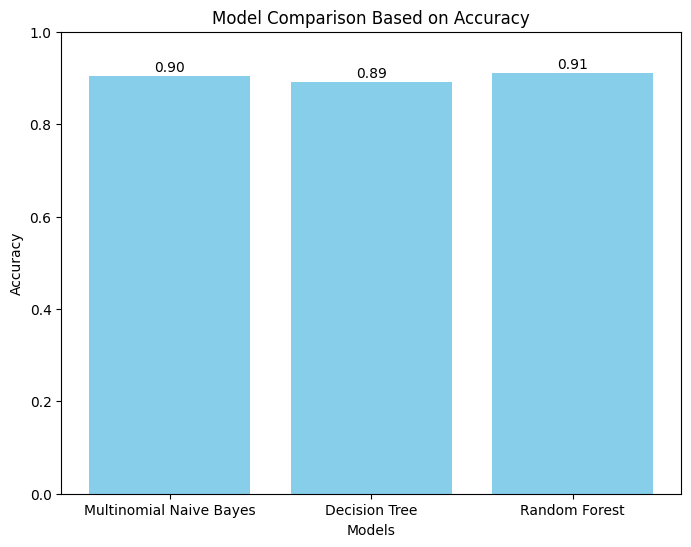

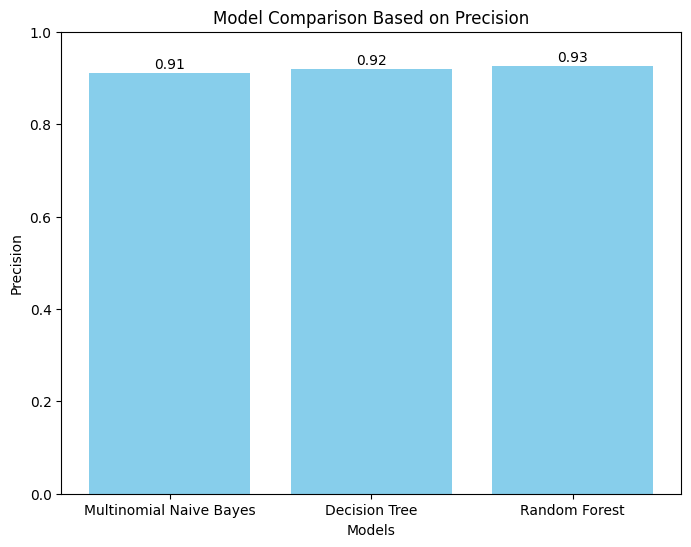

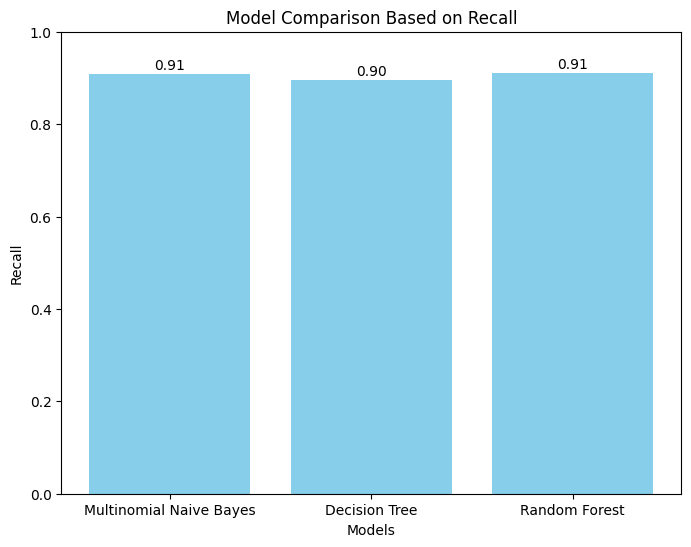

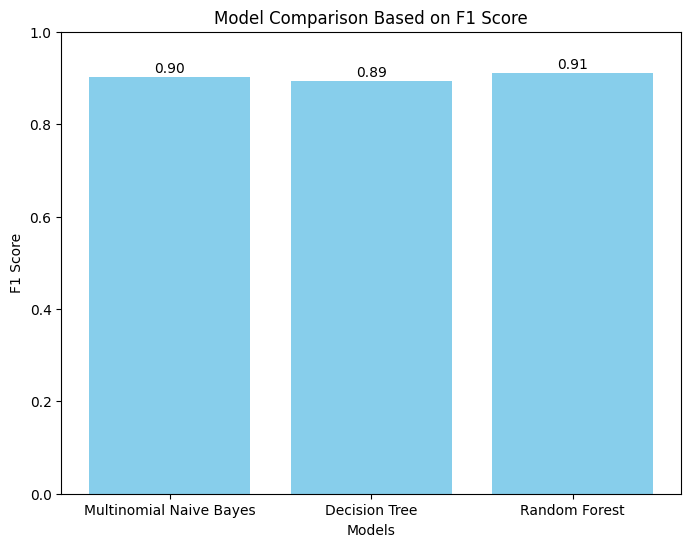

In [12]:
best_model = find_best_model_with_plots(X, y, test_size=0.2)

In [13]:
def chatbot_response(user_input):
    # Preprocess the input using our custom tokenizer
    processed_tokens = tokenizer.tokenize(user_input)
    filtered_tokens = [lemmatizer.lemmatize(token) for token in processed_tokens if token not in stopwords]
    processed_input = ' '.join(filtered_tokens)

    # Transform using our custom vectorizer
    input_vector = vectorizer.transform([processed_input])
    predicted_intent = best_model.predict(input_vector)[0]

    for intent in intents['intents']:
        if intent['tag'] == predicted_intent:
            response = random.choice(intent['responses'])
            break

    return response

In [14]:
print('Hello! I am a chatbot. How can I help you today? Type "quit" to exit.')
while True:
    user_input = input('> ')
    if user_input.lower() == 'quit':
        break
    response = chatbot_response(user_input)
    print(response)

Hello! I am a chatbot. How can I help you today? Type "quit" to exit.
> Hi
Good to see you!
> Food options available at IITJ
The college provides a variety of dining options on campus, including a functional canteen which is open till 2 am and food court named Shamiyana that is open till 12 am. The quality of food is generally satisfactory, with options to cater to different dietary preferences.
> quit


In [15]:
import os
from joblib import dump


if not os.path.exists('model'):
    os.makedirs('model')

# Save the trained model
dump(best_model, 'model/Random_forest.joblib')

# Save the vectorizer
dump(best_model, 'model/vectorizer.joblib')

['model/vectorizer.joblib']